In [1]:
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import sort
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import seaborn as sns
from time import time
import pprint
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper,DeltaYStopper
from skopt.space import Real,Categorical,Integer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import joblib
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

# Dataset

In [2]:
df0=pd.read_csv('Arrhthymia selected 28 features.csv')
df=df0.copy()
df.head()

,Weight,QRS duration,Q-T interval,Heart rate,Q wavechannel DIIII,R wavechannel DIIII,Number of intrinsic deflectionschannel V1,Q wavechannel V3,T wave,P wave DII,...,S wave V3,QRSTA V3,R wave V4,T wave V4,QRSTA V4,JJ wave V5,T wave V5,QRSTA V5,T wave V6,label
0,64,81,401,53,32,24,16,0,1.5,0.1,...,-7.7,27.7,9.5,2.6,34.6,-0.4,2.6,43.4,2.1,5
1,95,138,386,75,28,116,100,0,2.5,0.7,...,-4.1,23.3,10.0,2.2,20.7,1.3,3.4,48.2,3.4,7
2,94,100,380,71,20,52,0,0,1.9,0.4,...,-7.9,51.0,15.0,3.3,63.1,0.1,3.0,68.0,2.6,0
3,52,77,377,70,0,44,12,0,1.0,0.5,...,-11.0,21.2,7.7,1.9,15.4,0.0,1.3,18.9,1.0,0
4,54,78,376,67,0,56,8,0,1.0,0.6,...,-9.0,21.1,6.6,1.4,14.2,-0.2,0.8,20.9,0.5,0


In [3]:
X1=df.drop(labels=['label'],axis=1)

y1=df['label'].values

In [4]:
#stanardilization

scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)

In [5]:
X1_train, X1_test, y1_train, y1_test =train_test_split(X1, y1,test_size=0.20, random_state=0, stratify=y1)

# Model

## Light GBM

In [6]:
lgbm1 =LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=3, num_leaves=170,
                                learning_rate=0.01,n_estimators=237,
                                colsample_bytree= 0.8,subsample= 0.8)

In [7]:

lgbm_arrhthymia=lgbm1.fit(X1_train,y1_train)

In [8]:
start=datetime.now()
lgbm1.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_lgbm4='%.4f'%(stop-start).total_seconds()
print(execution_time_lgbm4)

0.2307


In [9]:
y_pred_lgbm1=lgbm1.predict((X1_test))
y_prob_lgbm1=lgbm1.predict_proba((X1_test))
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.7954545454545454
F1 score with LGBM is:  0.7954545454545455
ROC_AUC score with LGBM is:  0.921700954550441
Cross entropy loss score with LGBM is:  0.7194718981023356


In [10]:
lgbm_accuracy='%.4f'%accuracy_score(y1_test, y_pred_lgbm1)
lgbm_f1='%.4f'%f1_score(y1_test, y_pred_lgbm1,average='micro')
lgbm_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test))
lgbm_loss='%.4f'%log_loss(y1_test,y_prob_lgbm1)
print(lgbm_accuracy)
print(lgbm_f1)
print(lgbm_roc_auc)
print(lgbm_loss)

0.7955
0.7955
0.9217
0.7195


In [11]:
start=datetime.now()
accuracy_score_28 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_28 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_28 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_28 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()
stop=datetime.now()

execution_time_lgbm4=(stop-start)/20
execution_time_lgbm4

print("accuracy 28  feature:",accuracy_score_28)
print('F1 score 28  feature:',F1_score_28)
print('roc_auc 28  feature:',roc_auc_score_28)
print("cross entropy loss 28  feature:",neg_loss_score_28)


accuracy 28  feature: 0.76
F1 score 28  feature: 0.76
roc_auc 28  feature: 0.9170247418382509
cross entropy loss 28  feature: -0.748986586283361


In [12]:
training_time_lgbm=execution_time_lgbm4.total_seconds()
training_time_lgbm='%.4f'%training_time_lgbm
print(training_time_lgbm)

0.2428


In [13]:
# save the model
joblib.dump(lgbm_arrhthymia,'lgbm_arrhthymia.model')

['lgbm_arrhthymia.model']

In [14]:
rflgbm_arrhthymia=joblib.load('lgbm_arrhthymia.model')
   #应用模型进行预测
resultlgmb=rflgbm_arrhthymia.score(X1_test,y1_test)

In [15]:
resultlgmb

0.7954545454545454

## SVM 

In [16]:
svc1=SVC(probability=True, random_state=42
          ,C=10
           ,degree= 1
           ,gamma= 0.01
           ,kernel='rbf')

In [17]:

start=datetime.now()
svc1.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_svc='%.4f'%(stop-start).total_seconds()
print(execution_time_svc)

svc1.score(X1_test,y1_test)

0.0502


0.7727272727272727

In [18]:
svc_arrhthymia=svc1.fit(X1_train,y1_train)

In [19]:
start=datetime.now()
accuracy_score_28_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_28_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_28_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_28_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_svm=(stop-start)/20
execution_time_svm

print("accuracy 28  feature:",accuracy_score_28_svm)
print('F1 score 28  feature:',F1_score_28_svm)
print('roc_auc 28  feature:',roc_auc_score_28_svm)
print("cross entropy loss 28  feature:",neg_loss_score_28_svm)

accuracy 28  feature: 0.7314285714285714
F1 score 28  feature: 0.7314285714285714
roc_auc 28  feature: 0.9198924292229101
cross entropy loss 28  feature: -0.7992501752387569


In [20]:
training_time_svm=execution_time_svm.total_seconds()
training_time_svm='%.4f'%training_time_svm
print(training_time_svm)

0.0456


In [21]:
y_pred_svc1=svc1.predict(X1_test)
y_prob_svc1=svc1.predict_proba(X1_test)

In [22]:

svc_accuracy='%.4f'%accuracy_score(y1_test, y_pred_svc1)
svc_f1='%.4f'%f1_score(y1_test, y_pred_svc1,average='micro')
svc_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_svc1,multi_class='ovr',labels=np.unique(y1_test))
svc_loss='%.4f'%log_loss(y1_test,y_prob_svc1)
print(svc_accuracy)
print(svc_f1)
print(svc_roc_auc)
print(svc_loss)

0.7727
0.7727
0.9209
0.7466


In [23]:
  #保存模型
joblib.dump(svc_arrhthymia,'svc_arrhthymia.model')

['svc_arrhthymia.model']

In [24]:
#加载模型
RFsvc=joblib.load('svc_arrhthymia.model')
   #应用模型进行预测
resultsvc=RFsvc.score(X1_test,y1_test)

In [25]:
resultsvc

0.7727272727272727

## Random Forest

In [26]:
rf1= RFC(random_state=42, max_features='sqrt', n_estimators= 150,
                                     max_depth=15, 
                                     criterion='gini')

In [27]:
start=datetime.now()
accuracy_score_28_rf =cross_val_score(rf1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_28_rf =cross_val_score(rf1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_28_rf =cross_val_score(rf1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_28_rf =cross_val_score(rf1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_rf=(stop-start)/20
execution_time_rf

print("accuracy 28  feature:",accuracy_score_28_rf)
print('F1 score 28  feature:',F1_score_28_rf)
print('roc_auc 28  feature:',roc_auc_score_28_rf)
print("cross entropy loss 28  feature:",neg_loss_score_28_rf)

accuracy 28  feature: 0.7742857142857142
F1 score 28  feature: 0.7742857142857142
roc_auc 28  feature: 0.9314835702073692
cross entropy loss 28  feature: -0.7405504781779507


In [28]:
training_time_rf=execution_time_rf.total_seconds()
training_time_rf='%.4f'%training_time_rf
print(training_time_rf)

0.2601


In [29]:
rf_arrhthymia=rf1.fit(X1_train,y1_train)
y_pred_rf2=rf1.predict(X1_test)
y_prob_rf2=rf1.predict_proba(X1_test)

rf_accuracy='%.4f'%accuracy_score(y1_test, y_pred_rf2)
rf_f1='%.4f'%f1_score(y1_test, y_pred_rf2,average='micro')
rf_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test))
rf_loss='%.4f'%log_loss(y1_test,y_prob_rf2)
print(rf_accuracy)
print(rf_f1)
print(rf_roc_auc)
print(rf_loss)

0.7614
0.7614
0.9353
0.7221


In [30]:
# save the model
joblib.dump(rf_arrhthymia,'rf_arrhthymia.model')

['rf_arrhthymia.model']

In [31]:
   #加载模型
RFrf=joblib.load('rf_arrhthymia.model')
   #应用模型进行预测
rfresult=RFrf.score(X1_test,y1_test)

In [32]:
rfresult

0.7613636363636364

## ANN

In [33]:
arr=pd.read_csv('Arrhthymia selected 28 features.csv')
df1=arr.copy()

In [34]:
X11=df1.drop(labels=['label'],axis=1)
#stanardilization

scaler=StandardScaler()
scaler.fit(X11)
X11=scaler.transform(X11)
y11=df1['label'].values
X11_train, X11_test, y11_train, y11_test =train_test_split(X11, y11,test_size=0.20, random_state=0, stratify=y11)

In [35]:
X11_train = torch.from_numpy(X11_train)
y11_train = torch.from_numpy(y11_train ).type(torch.LongTensor)

X11_test  = torch.from_numpy(X11_test )
y11_test= torch.from_numpy(y11_test).type(torch.LongTensor)

batch_size = 128

train = torch.utils.data.TensorDataset(X11_train, y11_train )
test = torch.utils.data.TensorDataset(X11_test , y11_test)


train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)




In [36]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2, output_dim):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU() 
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


In [37]:
epochs =30

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = X1.shape[1]
hidden_dim1 = 40 #hidden layer1
hidden_dim2 = 128 #hidden layer2 
output_dim = len(set(y1))

In [38]:
model = ANNModel(input_dim, hidden_dim1,hidden_dim2,output_dim)


learning_rate = 0.0097
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()


In [39]:
start=datetime.now()
total_step = len(train_loader)
model.train()
for epoch in range(epochs):
    tot_loss = 0.0
    tot_acc = 0.0
    train_preds = []
    train_trues = []
  # model.train()
    for i,(train_data_batch, train_label_batch) in enumerate(train_loader):
        train_data_batch = train_data_batch.float().to(device) # 将double数据转换为float
        train_label_batch = train_label_batch.to(device)
        outputs = model(train_data_batch)
        # _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, train_label_batch)
        # print(loss)
        #反向传播优化网络参数
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #累加每个step的损失
        tot_loss += loss.data
        train_outputs = outputs.argmax(dim=1)
        train_preds.extend(train_outputs.detach().cpu().numpy())
        train_trues.extend(train_label_batch.detach().cpu().numpy())
        # tot_acc += (outputs.argmax(dim=1) == train_label_batch).sum().item()
        sklearn_accuracy = accuracy_score(train_trues, train_preds)
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        print("[sklearn_metrics] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch, tot_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
stop=datetime.now()
execution_time_ann=(stop-start)
training_time_ann='%.4f'%(execution_time_ann).total_seconds()
print(training_time_ann)
        
test_preds = []
test_trues = []
model.eval()
with torch.no_grad():
    for i,(test_data_batch, test_data_label) in enumerate(test_loader):
        test_data_batch = test_data_batch.float().to(device) # 将double数据转换为float
        test_data_label = test_data_label.to(device)
        test_outputs = model(test_data_batch)
        probs = F.softmax(test_outputs, dim=1) 
        test_outputs = test_outputs.argmax(dim=1)
        testloss = criterion(probs, test_data_label)
#         preds = torch.argmax(logits, dim=1)
        test_preds.extend(test_outputs.detach().cpu().numpy())
        test_trues.extend(test_data_label.detach().cpu().numpy())
        sklearn_accuracy = accuracy_score(test_trues, test_preds)
        sklearn_precision = precision_score(test_trues, test_preds, average='micro')
        sklearn_recall = recall_score(test_trues, test_preds, average='micro')
        sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
        print(classification_report(test_trues, test_preds))
        conf_matrix = confusion_matrix(test_trues, test_preds)
        print(conf_matrix)
#         plot_confusion_matrix(conf_matrix)
        print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

[sklearn_metrics] Epoch:0 loss:2.1673 accuracy:0.1797 precision:0.1797 recall:0.1797 f1:0.1797
[sklearn_metrics] Epoch:0 loss:9.7689 accuracy:0.3672 precision:0.3672 recall:0.3672 f1:0.3672
[sklearn_metrics] Epoch:0 loss:12.3275 accuracy:0.3143 precision:0.3143 recall:0.3143 f1:0.3143
[sklearn_metrics] Epoch:1 loss:1.9341 accuracy:0.1562 precision:0.1562 recall:0.1562 f1:0.1562
[sklearn_metrics] Epoch:1 loss:3.5017 accuracy:0.3867 precision:0.3867 recall:0.3867 f1:0.3867
[sklearn_metrics] Epoch:1 loss:4.9143 accuracy:0.4657 precision:0.4657 recall:0.4657 f1:0.4657
[sklearn_metrics] Epoch:2 loss:1.4231 accuracy:0.5469 precision:0.5469 recall:0.5469 f1:0.5469
[sklearn_metrics] Epoch:2 loss:2.4834 accuracy:0.6406 precision:0.6406 recall:0.6406 f1:0.6406
[sklearn_metrics] Epoch:2 loss:3.7005 accuracy:0.6543 precision:0.6543 recall:0.6543 f1:0.6543
[sklearn_metrics] Epoch:3 loss:0.9505 accuracy:0.7109 precision:0.7109 recall:0.7109 f1:0.7109
[sklearn_metrics] Epoch:3 loss:1.6624 accuracy:0.

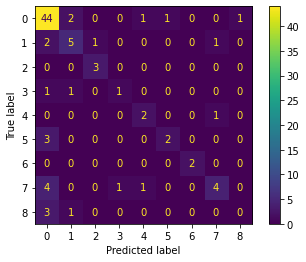

In [40]:
ConfusionMatrixDisplay.from_predictions(test_trues, test_preds)

plt.show()

In [41]:
print(classification_report(test_trues, test_preds,zero_division=1))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83        49
           1       0.56      0.56      0.56         9
           2       0.75      1.00      0.86         3
           3       0.50      0.33      0.40         3
           4       0.50      0.67      0.57         3
           5       0.67      0.40      0.50         5
           6       1.00      1.00      1.00         2
           7       0.67      0.40      0.50        10
           8       0.00      0.00      0.00         4

    accuracy                           0.72        88
   macro avg       0.60      0.58      0.58        88
weighted avg       0.68      0.72      0.69        88



In [42]:
print(accuracy_score(test_trues, test_preds))

0.7159090909090909


<AxesSubplot:>

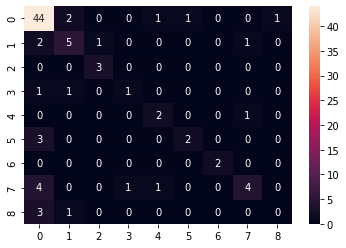

In [43]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_trues, test_preds))

sns.heatmap(confusion_matrix_df, annot=True)

In [44]:
testloss

tensor(1.6746)

In [45]:
 print("AUC score is: ", roc_auc_score(test_trues,probs,multi_class='ovr',labels=np.unique(test_trues)))

AUC score is:  0.8799428666877454


In [46]:
 print("Loss score is: ", log_loss(test_trues,probs))

Loss score is:  1.8800901276384925


In [47]:
training_time_ann

'0.4577'

In [48]:
ann_accuracy='%.4f'% accuracy_score(test_trues, test_preds)


ann_f1='%.4f'% f1_score(test_trues, test_preds, average='micro')


ann_roc_auc='%.4f'% roc_auc_score(test_trues,probs,multi_class='ovr',labels=np.unique(test_trues))


In [49]:
ann_roc_auc='%.4f'% roc_auc_score(test_data_label,probs,multi_class='ovr',labels=np.unique(test_data_label))


In [50]:
ann_roc_auc

'0.8799'

In [51]:
ann_loss='%.4f'% testloss


In [52]:
Arrdict = { 
              'accuracy':[lgbm_accuracy,svc_accuracy,rf_accuracy,ann_accuracy],
               'f1_score': [lgbm_f1,svc_f1,rf_f1,ann_f1],
               'roc_auc': [lgbm_roc_auc,svc_roc_auc,rf_roc_auc,ann_roc_auc],
               'cross_entropy_loss': [lgbm_loss,svc_loss,rf_loss,ann_loss],
                'training_time[s]':[training_time_lgbm,training_time_svm,training_time_rf,training_time_ann]
               }
pr_df_arr = pd.DataFrame(Arrdict,index=['Light GBM','SVM','Random Forest','PyTorch ANN'])
pr_df_arr

,accuracy,f1_score,roc_auc,cross_entropy_loss,training_time[s]
Light GBM,0.7955,0.7955,0.9217,0.7195,0.2428
SVM,0.7727,0.7727,0.9209,0.7466,0.0456
Random Forest,0.7614,0.7614,0.9353,0.7221,0.2601
PyTorch ANN,0.7159,0.7159,0.8799,1.6746,0.4577


In [54]:
pr_df_arr.to_csv('Arrhthymia Score.csv')